## Lab: Time-Series Regression using ARIMA model

### What is an ARIMA?

ARIMA stands for Auto-Regresssive Integrated Moving Average.  It is essentially a linear regression model for time-series data. When we watch a variable change over time, we can develop a model to help predict future movements.

### Our Dataset

Our dataset is a simple one that contains a time-series of product sales, by month.  The same principle could be used to predict equities, commodities, or any other time-series data.  Of course, the usual caveats apply about applying this naively, particularly in finance.

In [3]:
%matplotlib inline
import pandas as pd
sales = pd.read_csv('/data/product-sales/product-sales.csv',
                    parse_dates=[0], index_col=0, date_parser=lambda x: pd.datetime.strptime('200'+x, '%Y-%m'))
sales

,Sales
Month,
2001-01-01,266.0
2001-02-01,145.9
2001-03-01,183.1
2001-04-01,119.3
2001-05-01,180.3
2001-06-01,168.5
2001-07-01,231.8
2001-08-01,224.5
2001-09-01,192.8


### Let's see a plot of the data

We can see a simple plot using matplotlib and pandas. Note that sales appear to vary significantly month to month, as we would expect.

```python
sales.plot()
```

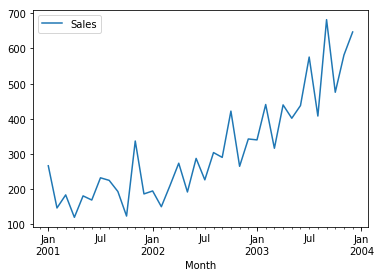

In [4]:
import matplotlib.pyplot as plt

sales.plot()

### AutoCorrelation

We might fairly ask whether past values of sales truly appear to be correlated with future results.  If not, then ARIMA models will prove to be of little value.

We can do an autocorrelation to see what past correlation prior values have proven to be 

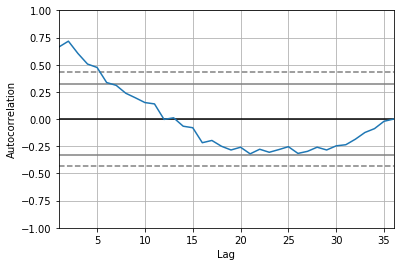

In [5]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(sales)

### Interpreting Autocorrelation

What we see, is that recent sales numbers were indeed quite closely positively correlated with future numbers. However, past about 5 months, we see that correlation becomes weak and in fact eventually weakly negative, meaning that sales tended to move in the opposite direction. 

We can conclude, however, that recent months are a reasonably good predictor, although surely not the only factor driving sales.

# Dickey-Fuller


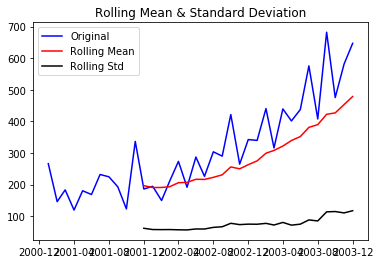

Results of Dickey-Fuller Test:


ValueError: too many values to unpack (expected 2)

In [8]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(sales)

### ARIMA Model

We will use statsmodels for this.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(sales, order=(5,1,0), freq=sales.index.inferred_freq).fit()
model.summary()

### Residuals Analysis

Residuals are simply the difference between what was predicted and what we actually saw.  Let's do some analysis of residuals to see if any trends can be discerned.

In [ ]:
residuals = pd.DataFrame(model.resid)
print(residuals.describe())

In [ ]:
residuals.plot(kind="kde") #skewed to the left, interesting!

In [ ]:
# Split into training and test
# Note we are not using train_test_split, because we want sequential
# not random values. 

size = int(len(sales.values) * 0.66)
train, test = sales.values[0:size], sales.values[size:len(sales.values)]


In [ ]:
train

In [ ]:
history = [x for x in train]
predictions = list()
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0)).fit(disp=0)
	output = model.forecast()
	predictions.append(output[0])
	history.append(test[t])
	print('%d: predicted=%f, expected=%f' % (t, output[0], test[t]))


In [ ]:
from sklearn.metrics import mean_squared_error
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
